In this notebook we train a RealNVP based flow model to approximate the Double Well Boltzmann Distribution.
Scroll down to the bottom for visualisation of results. 

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
import normflow as nf
import matplotlib.pyplot as plt
import torch

from fab import FABModel, HamiltoneanMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from examples.make_flow import make_wrapped_normflowdist

from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab.train_with_prioritised_buffer import PrioritisedBufferTrainer

/home/laurence/miniconda3/envs/fabtorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure Training

In [4]:
dim: int = 2
n_intermediate_distributions: int = 2
layer_nodes_per_dim = 5
batch_size: int = 128
n_iterations: int = 1000
n_eval = 100
eval_batch_size = batch_size * 10
n_plots: int = 20 # number of plots shows throughout tranining
lr: float = 1e-4
transition_operator_type: str = "metropolis" # "metropolis" or "hmc"
seed: int = 1
n_flow_layers: int = 10
# torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

In [5]:
# buffer config
n_batches_buffer_sampling = 4
maximum_buffer_length = batch_size * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

## Setup GMM target distribution

In [6]:
loc_scaling = 40
n_mixes = 40

In [7]:
from fab.target_distributions.gmm import GMM
torch.manual_seed(seed)
target = GMM(dim=dim, n_mixes=n_mixes, loc_scaling=loc_scaling, log_var_scaling=1.0)
plotting_bounds = (-loc_scaling*1.4, loc_scaling*1.4)

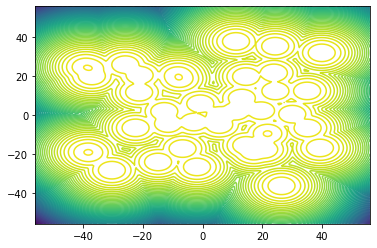

In [8]:
# plot target
fig, ax = plt.subplots()
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)

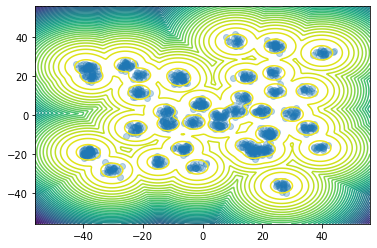

In [9]:
# plot target
fig, ax = plt.subplots()
samples = target.sample((1000,))
ax.plot(samples[:, 0], samples[:, 1], "o", alpha=0.3)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=50, ax=ax, grid_width_n_points=200)

## Setup Flow
By wrapping the [normflow library](https://github.com/VincentStimper/normalizing-flows). 

In [10]:
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = True)

/home/laurence/miniconda3/envs/fabtorch/lib/python3.7/site-packages/normflow/flows/mixing.py:147: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1980.)
  Q = torch.qr(torch.randn(self.num_channels, self.num_channels))[0]


## Setup transition operator

In [11]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=5, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     max_step_size=1.0,
                                     n_updates=1, adjust_step_size=True)
else:
    raise NotImplementedError

## Define model, trainer and plotter

In [12]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger(save=False) # save training history

using linear spacing as there are only 2 intermediate distribution


In [13]:
def plot(fab_model, n_samples = 300):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[2], n_contour_levels=50, grid_width_n_points=200)

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0]
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    
    # plot buffer samples
    samples_buffer = buffer.sample(n_samples)[0]
    plot_marginal_pair(samples_buffer, ax=axs[2], bounds=plotting_bounds)
    
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    axs[2].set_title("buffer samples")
    plt.show()

In [14]:
# buffer
def initial_sampler():
    x, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    log_q_x = fab_model.flow.log_prob(x)
    return x, log_w, log_q_x
buffer = PrioritisedReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)

In [15]:
trainer = PrioritisedBufferTrainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler,
                        buffer=buffer,
                        n_batches_buffer_sampling=n_batches_buffer_sampling,
                     max_gradient_norm=0.1)

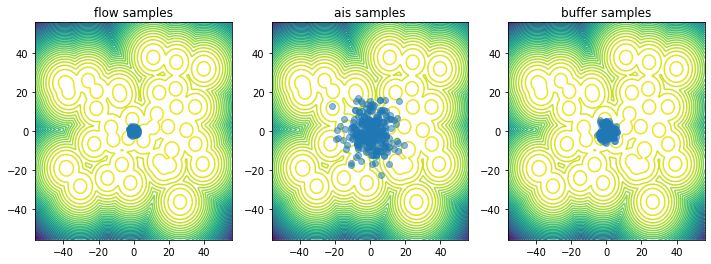

In [16]:
plot(fab_model)

# Run with visualisation

loss: 4.1697187423706055, ess base: 0.016041431576013565,ess ais: 0.0078125:   0%|                                                                                                                             | 0/1000 [00:00<?, ?it/s]../fab/utils/numerical.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  expectation = normalised_importance_weights.T @ function_values


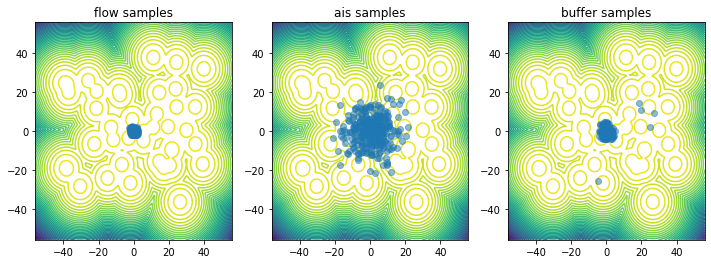

loss: 1.627562403678894, ess base: 0.017297791317105293,ess ais: 0.008048967458307743:   5%|█████▍                                                                                                    | 51/1000 [00:10<03:55,  4.03it/s]

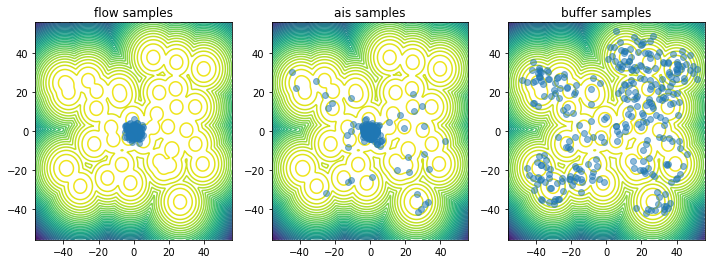

loss: 6.7129316329956055, ess base: 0.009917241521179676,ess ais: 0.02000601775944233:  10%|███████████                                                                                              | 105/1000 [00:20<02:32,  5.85it/s]

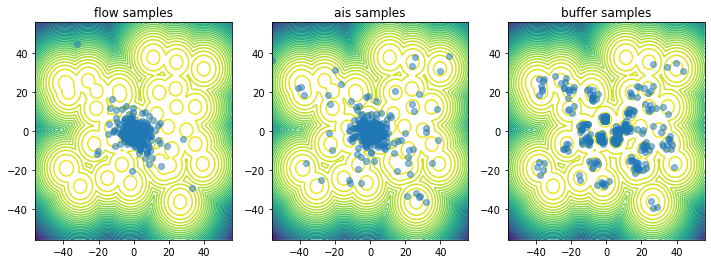

loss: 7.312086582183838, ess base: 0.04586215689778328,ess ais: 0.016758540645241737:  12%|████████████▋                                                                                             | 120/1000 [00:23<01:54,  7.70it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 7.233757019042969, ess base: nan,ess ais: 0.012229903601109982:  13%|███████████████▎                                                                                                          | 126/1000 [00:24<02:26,  5.97it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 7.7166032791137695, ess base: 0.017448758706450462,ess ais: 0.02707522362470627:  14%|██████████████▎                                                                                          | 136/1000 [00:26<02:35,  5.55it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 7.781435489654541, ess base: 0.01279501337558031,ess ais: 0.012813182547688484:  14%|██████████████▊                                                                                           | 140/1000 [00:27<01:53,  7.58it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 7.7923736572265625, ess base: 0.013180620968341827,ess ais: 0.022738397121429443:  14%|██████████████▋                                                                                         | 141/1000 [00:27<01:47,  8.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.681960582733154, ess base: 0.01983492821455002,ess ais: 0.022135009989142418:  14%|███████████████                                                                                           | 142/1000 [00:28<04:42,  3.04it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 7.9548258781433105, ess base: 0.08793403208255768,ess ais: 0.013927496038377285:  15%|███████████████▋                                                                                         | 149/1000 [00:28<01:53,  7.48it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.995296478271484, ess base: 0.009828031994402409,ess ais: 0.0146908238530159:  15%|████████████████▏                                                                                          | 151/1000 [00:29<01:40,  8.43it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.205771446228027, ess base: 0.011158792302012444,ess ais: 0.011440646834671497:  15%|████████████████                                                                                         | 153/1000 [00:30<03:38,  3.88it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 7.971567153930664, ess base: 0.019447749480605125,ess ais: 0.021158091723918915:  16%|████████████████▎                                                                                        | 155/1000 [00:30<02:43,  5.18it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.21778392791748, ess base: nan,ess ais: 0.0238319244235754:  16%|███████████████████▋                                                                                                         | 157/1000 [00:30<02:10,  6.48it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.


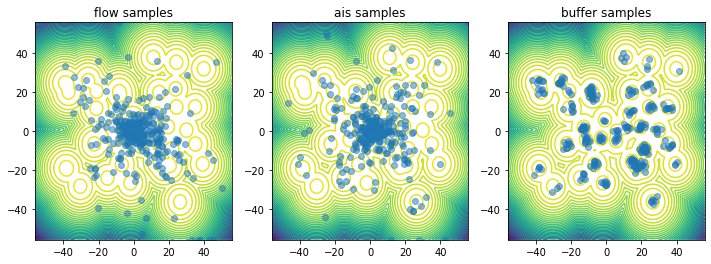

loss: 8.68758487701416, ess base: 0.012158472090959549,ess ais: 0.019201980903744698:  16%|█████████████████                                                                                         | 161/1000 [00:31<02:28,  5.65it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.379332542419434, ess base: 0.008304012008011341,ess ais: 0.008464904502034187:  16%|█████████████████                                                                                        | 162/1000 [00:32<05:27,  2.56it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.295693397521973, ess base: 0.0307302325963974,ess ais: 0.03146105632185936:  17%|██████████████████▏                                                                                         | 168/1000 [00:33<02:08,  6.45it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.626005172729492, ess base: 0.019380321726202965,ess ais: 0.0226148571819067:  17%|██████████████████▏                                                                                        | 170/1000 [00:33<01:50,  7.52it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.301243782043457, ess base: 0.032827865332365036,ess ais: 0.03284643590450287:  17%|██████████████████                                                                                        | 170/1000 [00:33<01:50,  7.52it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.624277114868164, ess base: nan,ess ais: 0.023394234478473663:  18%|██████████████████████                                                                                                    | 181/1000 [00:35<01:41,  8.10it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.5339937210083, ess base: 0.016280105337500572,ess ais: 0.01659802719950676:  18%|███████████████████▊                                                                                        | 183/1000 [00:36<03:38,  3.74it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.479289054870605, ess base: 0.031323302537202835,ess ais: 0.020156364887952805:  19%|███████████████████▌                                                                                     | 186/1000 [00:36<02:17,  5.91it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.630793571472168, ess base: 0.0281391479074955,ess ais: 0.02914571203291416:  19%|████████████████████▋                                                                                       | 192/1000 [00:37<04:36,  2.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.584903717041016, ess base: 0.008079099468886852,ess ais: 0.00808045919984579:  19%|████████████████████▌                                                                                     | 194/1000 [00:38<03:01,  4.45it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.468740463256836, ess base: 0.02019990235567093,ess ais: 0.02874266915023327:  20%|█████████████████████▌                                                                                     | 201/1000 [00:38<01:35,  8.35it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
1 nan/inf samples/log-probs/log-weights encountered at chain end.
2 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.5826416015625, ess base: 0.0545988492667675,ess ais: 0.054666079580783844:  21%|██████████████████████▉                                                                                      | 210/1000 [00:40<01:35,  8.28it/s]

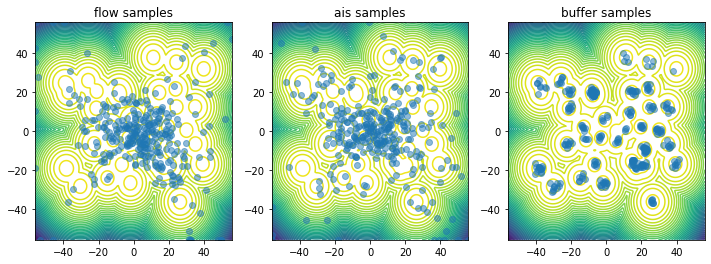

loss: 8.668779373168945, ess base: 0.04240912199020386,ess ais: 0.05260771885514259:  21%|██████████████████████▌                                                                                    | 211/1000 [00:41<03:43,  3.53it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.640286445617676, ess base: 0.02198721654713154,ess ais: 0.02216467820107937:  22%|███████████████████████▊                                                                                   | 223/1000 [00:44<03:45,  3.44it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain end.


loss: 8.755935668945312, ess base: 0.03165123984217644,ess ais: 0.0317598320543766:  26%|████████████████████████████▎                                                                               | 262/1000 [00:50<01:26,  8.49it/s]

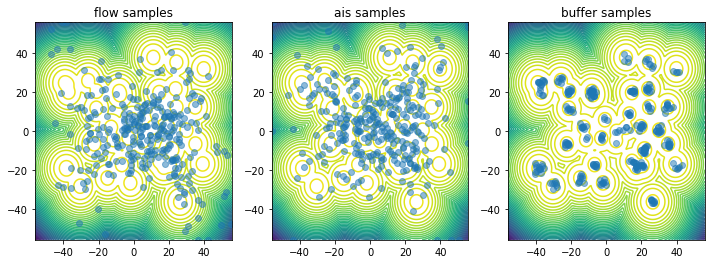

loss: 8.504058837890625, ess base: 0.0701100155711174,ess ais: 0.06533396244049072:  32%|██████████████████████████████████                                                                          | 315/1000 [01:01<02:31,  4.53it/s]

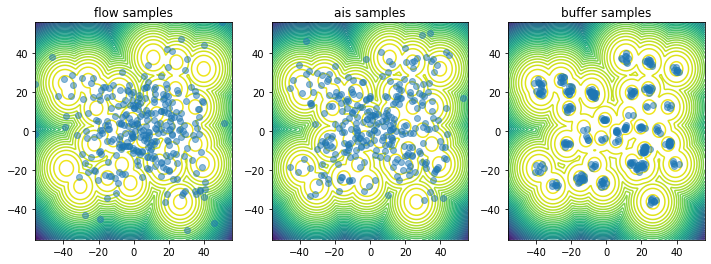

loss: 8.613168716430664, ess base: 0.012862795032560825,ess ais: 0.013204642571508884:  36%|█████████████████████████████████████▊                                                                   | 360/1000 [01:09<01:32,  6.95it/s]

nan loss in replay step


loss: 8.609609603881836, ess base: 0.018555928021669388,ess ais: 0.01920897141098976:  37%|███████████████████████████████████████                                                                   | 368/1000 [01:11<01:51,  5.65it/s]

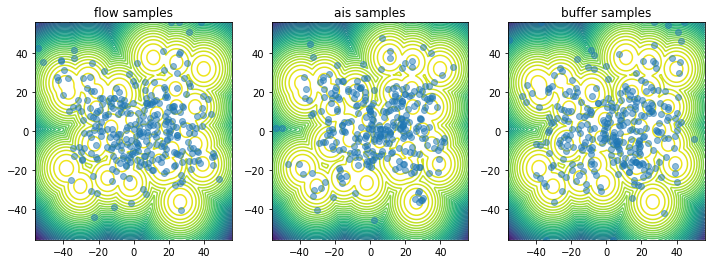

loss: 8.610607147216797, ess base: 0.04891473427414894,ess ais: 0.051723018288612366:  42%|████████████████████████████████████████████▌                                                             | 420/1000 [01:21<01:23,  6.97it/s]

loss: 8.737635612487793, ess base: 0.014112102799117565,ess ais: 0.0078125:  47%|██████████████████████████████████████████████████████▊                                                             | 473/1000 [01:31<01:08,  7.72it/s]

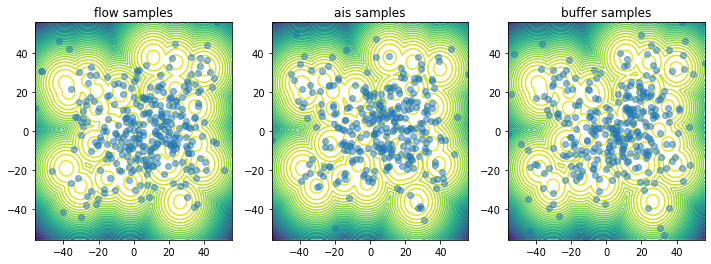

loss: nan, ess base: 0.0816124826669693,ess ais: 0.0078125:  48%|██████████████████████████████████████████████████████████████▊                                                                     | 476/1000 [01:32<01:42,  5.12it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


Exception: No valid points generated in sampling the chain init

In [17]:
# the nan's that arrise during the training are typically extreme flow samples (e.g. x=[100, 100]), 
# which give Nan values for the target density. However, these do not harm long term training.
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)

In the below plot:
ess = effective sample size
"Distance" refers to the distance moved during each intermediate transition. 

In [ ]:
plot_history(logger.history)

## Visualise Trained Flow Model

In [ ]:
# plot samples on top of contours
n_samples = 500
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50)
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50)
# plot flow samples
samples_flow = fab_model.flow.sample((n_samples,))
plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)
axs[0].set_title("flow samples vs target contours")
# plot ais samples
samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                           logging=False)[0]
plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
axs[1].set_title("ais samples vs target contours")


samples = target.sample((1000,))
axs[2].plot(samples[:, 0], samples[:, 1], "o", alpha=0.3)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=50, ax=axs[2])
axs[2].set_title("target samples vs target contours")
plt.tight_layout()